In [52]:
# -*- coding: UTF-8 -*-
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str, zip
import re
import os
from glob import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.svm import LinearSVC
from gensim.models.word2vec import Word2Vec
from nlputils.features import preprocess_text
from nlputils.simmat import dist2kernel
from nlputils.embedding import proj2d
from nlputils.visualize import basic_viz, get_colors
from word_emb_sim import compute_w2v_K, transform_word2vec_featmat

py.init_notebook_mode()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data and bootstrap emotion labels

In [64]:
# load posts with partially annotated categories
df = pd.read_csv("data/posts_categories.tsv", sep="\t")
posts = {}
post_categories = {}
post_likes = {}
post_love = {}
post_haha = {}
post_sad = {}
post_wow = {}
post_angry = {}
# read in all posts and (if available) category
for i in range(len(df)):
    if not pd.isna(df.iloc[i]["link"]) and not pd.isna(df.iloc[i]["post_message"]):
        posts[df.iloc[i]["post_id"]] = df.iloc[i]["post_message"]
        # count reactions
        post_likes[df.iloc[i]["post_id"]] = df.iloc[i]["likes_count_fb"]
        post_love[df.iloc[i]["post_id"]] = df.iloc[i]["rea_LOVE"]
        post_haha[df.iloc[i]["post_id"]] = df.iloc[i]["rea_HAHA"]
        post_sad[df.iloc[i]["post_id"]] = df.iloc[i]["rea_SAD"]
        post_wow[df.iloc[i]["post_id"]] = df.iloc[i]["rea_WOW"]
        post_angry[df.iloc[i]["post_id"]] = df.iloc[i]["rea_ANGRY"]
        if not pd.isna(df.iloc[i]["Kategorien "]):
            post_categories[df.iloc[i]["post_id"]] = df.iloc[i]["Kategorien "]
            # for articles we can also extract the headline from the url
            if not df.iloc[i]["link_domain"] == "facebook.com":
                link = df.iloc[i]["link"]
                if df.iloc[i]["link_domain"] == "m.exactag.com":
                    link = link.split("bild-plus%2F")[1].replace("%2F", " ")
                else:
                    link = link.split(df.iloc[i]["link_domain"])[1]
                posts[df.iloc[i]["post_id"]] += " " + " ".join(re.findall("[A-Za-z]+", re.sub("[0-9]+.bild.html", "", link)))
        # preprocess text and manually add emojis again
        pp = preprocess_text(df.iloc[i]["post_message"])
        char_counts = Counter(list(df.iloc[i]["post_message"]))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp += " " + " ".join(char_counts[c]*[c])
        posts_pp[df.iloc[i]["post_id"]] = pp

In [43]:
# read in sentiment words
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Negative-21042012.tsv", sep="\t", header=None)
sent_neg = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Positive-21042012.tsv", sep="\t", header=None)
sent_pos = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Neutral-21042012.tsv", sep="\t", header=None)
sent_neu = set(preprocess_text(t) for t in df[0])
# read in emotion words and assign to 4 emotions
# https://www.microsoft.com/developerblog/2015/11/29/emotion-detection-and-recognition-from-text-using-deep-learning/
df = pd.read_csv("data/emotion_words/Ekel.txt", sep="\t", header=None)
emo_anger = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Verachtung.txt", sep="\t", header=None)
emo_anger.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("data/emotion_words/Wut.txt", sep="\t", header=None)
emo_anger.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("data/emotion_words/Furcht.txt", sep="\t", header=None)
emo_fear = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Freude.txt", sep="\t", header=None)
emo_happy = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Ueberraschung.txt", sep="\t", header=None)
emo_happy.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("data/emotion_words/Trauer.txt", sep="\t", header=None)
emo_sad = set(preprocess_text(t) for t in df[0])
# define emotion emojis
# https://www.insight-centre.org/sites/default/files/publications/ianwood-emotionworkshop.pdf
emojis_happy = set("😀😃😄😁😆😅😂🤣☺😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤩😎😺😸😹😻😽🙌👏👍✌👌🎉❤💕💞💓💗💖♥")
emojis_sad = set("😞😔😟😕🙁☹😣😖😫😩😢😭😥😶😐😧😦😪😿🙀👎💔")
emojis_anger = set("😒😑😤😠😡🤬😾🖕💩👿")
emojis_fear = set("😱😳😨😰😵😧😮😲🙀")
emotions_list = ["happy", "sad", "fear", "anger", "-"]

def label_word_sent(w):
    sent_label = 0.
    if w in sent_neg:
        sent_label = -1.
    elif w in sent_pos:
        sent_label = +1.
    return sent_label

def label_word_emo(w):
    emo_label = "-"
    if w in emo_anger:
        emo_label = "anger"
    elif w in emo_fear:
        emo_label = "fear"
    elif w in emo_happy:
        emo_label = "happy"
    elif w in emo_sad:
        emo_label = "sad"
    return emo_label

In [47]:
# read in comments for all posts
comments = {i: {} for i in posts}
comments_pp = {i: {} for i in posts}
number_of_words = {i: {} for i in posts}
sent_scores = {i: {} for i in posts}
emo_anger_scores = {i: {} for i in posts}
emo_fear_scores = {i: {} for i in posts}
emo_sad_scores = {i: {} for i in posts}
emo_happy_scores = {i: {} for i in posts}
emo_main_label = {i: {} for i in posts}
df = pd.read_csv("data/all_comments.csv", sep="\t")
for i in range(len(df)):
    post_id, comment_message = df.iloc[i]["post_id"], df.iloc[i]["comment_message"]
    comment_id = post_id + " %i" % i
    if post_id in comments and not pd.isna(comment_message) and preprocess_text(comment_message):
        comments[post_id][comment_id] = comment_message
        pp_l = preprocess_text(comment_message)
        # based on the preprocessed words, get sentiment and word based emotion scores
        sent_scores[post_id][comment_id] = np.mean([label_word_sent(word) for word in pp_l.split()])
        emotions = Counter([label_word_emo(word) for word in pp_l.split()])
        # add scores based on emojis (from non-preprocessed text!)
        char_counts = Counter(list(comment_message))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp_l += " " + " ".join(char_counts[c]*[c])
                if c in emojis_anger:
                    emotions["anger"] += char_counts[c]
                elif c in emojis_fear:
                    emotions["fear"] += char_counts[c]
                elif c in emojis_happy:
                    emotions["happy"] += char_counts[c]
                elif c in emojis_sad:
                    emotions["sad"] += char_counts[c]
        comments_pp[post_id][comment_id] = pp_l
        n_tokens = len(pp_l.split())
        number_of_words[post_id][comment_id] = n_tokens
        emotions["-"] = 0
        emo_main_label[post_id][comment_id] = max(emotions, key=emotions.get)
        emo_anger_scores[post_id][comment_id] = emotions["anger"]/n_tokens
        emo_fear_scores[post_id][comment_id] = emotions["fear"]/n_tokens
        emo_sad_scores[post_id][comment_id] = emotions["sad"]/n_tokens
        emo_happy_scores[post_id][comment_id] = emotions["happy"]/n_tokens

## Refine labels

### Train word2vec embeddings

In [61]:
# get all comments and posts as lists of lists
sentences = []
for post_id in posts_pp:
    posts_pp[post_id] = posts_pp[post_id].split()
    sentences.append(posts_pp[post_id])
    for i in comments_pp[post_id]:
        comments_pp[post_id][i] = comments_pp[post_id][i].split()
        sentences.append(comments_pp[post_id][i])

AttributeError: 'list' object has no attribute 'split'

In [49]:
# train word2vec model
model = Word2Vec(sentences, size=100, window=10, min_count=3, workers=4)
word_vectors = model.wv
del model
word_vectors.init_sims(replace=True)

In [50]:
word_vectors.most_similar(positive=['🙈'])

[('🙊', 0.7711071968078613),
 ('😅', 0.7278887629508972),
 ('🙉', 0.6804074645042419),
 ('🙄', 0.6283605098724365),
 ('😜', 0.5754059553146362),
 ('😂', 0.569149911403656),
 ('😳', 0.5472027063369751),
 ('\U0001f92a', 0.5367310047149658),
 ('😉', 0.5164534449577332),
 ('😬', 0.5119187831878662)]

### Get missing post categories

In [68]:
train_ids = sorted(post_categories.keys())
test_ids = sorted([p for p in posts.keys() if not p in train_ids])
posts_train = transform_word2vec_featmat(posts_pp, train_ids, word_vectors, avg='simple avg')
posts_test = transform_word2vec_featmat(posts_pp, test_ids, word_vectors, avg='simple avg')
y = np.array([post_categories[p] for p in train_ids])
clf = LinearSVC(class_weight='balanced')
clf.fit(posts_train, y)
print(np.mean(y==clf.predict(posts_train)))
y_pred_test = clf.predict(posts_test)
for i, pid in enumerate(test_ids):
    post_categories[pid] = y_pred_test[i]

0.8633879781420765


In [69]:
# visualize posts
ids = train_ids + test_ids
textdict = {did: "<br>".join([" ".join(posts[did].split()[i:min(i+5, len(posts[did].split()))]) for i in range(0, len(posts[did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, posts_pp, word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

performing tSNE: 1418 datapoints
Iteration 25: error is 4.34127
Iteration 50: error is 4.46853
Iteration 75: error is 4.78265
Iteration 100: error is 4.69234
Iteration 125: error is 2.82901
Iteration 150: error is 2.38902
Iteration 175: error is 2.23721
Iteration 200: error is 2.17052
Iteration 225: error is 2.15266
Iteration 250: error is 2.13919
Iteration 275: error is 2.11866
Iteration 300: error is 2.10327
Iteration 325: error is 2.09304
Iteration 350: error is 2.08645
Iteration 375: error is 2.08152
Iteration 400: error is 2.07787
Iteration 425: error is 2.07499
Iteration 450: error is 2.07276
Iteration 475: error is 2.07104
Iteration 500: error is 2.06967
Iteration 525: error is 2.06857
Iteration 550: error is 2.06765
Iteration 575: error is 2.06680
Iteration 600: error is 2.06602
Iteration 625: error is 2.06467
Iteration 650: error is 2.06409
Iteration 675: error is 2.06369
Iteration 700: error is 2.06329
Iteration 725: error is 2.06294
Iteration 750: error is 2.06257
Iteration 

In [71]:
def create_fig_cats(doc_ids, doccats, x, y, textdict, title):
    categories = sorted(set(doccats.values()))
    colorlist = get_colors(len(categories))
    colordict = {cat: "rgb(%i,%i,%i)" % (255 * colorlist[i][0], 255 * colorlist[i][1], 255 * colorlist[i][2]) for i, cat in enumerate(categories)}
    data = []
    for j, cat in enumerate(categories):
        # get docids that belong to the current category
        didx_temp = [i for i, did in enumerate(doc_ids) if cat == doccats[did]]
        trace = go.Scatter(
                    x=x[didx_temp],
                    y=y[didx_temp],
                    mode='markers',
                    marker=dict(
                        size='10',
                        opacity=0.6,
                        color=colordict[cat]
                    ),
                    text=[textdict[did] for did in doc_ids if cat == doccats[did]],
                    hoverinfo='text',
                    name=cat
                )
        data.append(trace)
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False),
                showlegend=True
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

def create_fig_scores(doc_ids, docscores, x, y, textdict, title):
    trace = go.Scatter(
                    x = x,
                    y = y,
                    mode = 'markers',
                    marker=dict(
                        size='10',
                        opacity=0.8,
                        color = [docscores[i] for i in ids],
                        showscale=True
                    ),
                    text = [textdict[i] for i in ids],
                    hoverinfo='text'
            )
    data = [trace]
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False)
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

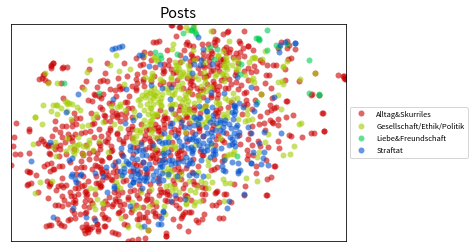

In [70]:
# basic non-interactive plot
categories = sorted(set(post_categories.values()))
basic_viz(ids, post_categories, x, y, dict(zip(categories, categories)), "Posts")

In [72]:
# interactive plots
fig_cats = create_fig_cats(ids, post_categories, x, y, textdict, "Posts")
py.iplot(fig_cats)

### Relabel comments with emotions

In [74]:
post_ids = sorted(posts.keys())
print("getting comment vectors")
comment_vectors = [transform_word2vec_featmat(comments_pp[p], sorted(comments_pp[p]), word_vectors, avg='simple avg') for p in post_ids]
print("getting comment labels")
y = []
for p in post_ids:
    y.extend([emo_main_label[p][c] for c in sorted(emo_main_label[p])])
y = np.array(y)
print("training clf")
clf = LinearSVC(class_weight='balanced')
clf.fit(np.vstack(comment_vectors), y)
print(np.mean(y==clf.predict(np.vstack(comment_vectors))))
print("generating new labels")
for i, p in enumerate(post_ids):
    y_pred_test = clf.predict(comment_vectors[i])   
    for j, c in enumerate(sorted(emo_main_label[p])):
        emo_main_label[p][c] = y_pred_test[j]

/Users/franzi/Documents/projects/zzarchive/emotion_analysis_ramona/word_emb_sim.py:161: RuntimeWarning:

invalid value encountered in true_divide



0.700970303951311


In [77]:
# visualize
pid = post_ids[5]
print(posts[pid])
print(post_categories[pid])
ids = np.random.permutation(list(comments_pp[pid]))[:3000]
textdict = {did: "<br>".join([" ".join(comments[pid][did].split()[i:min(i+5, len(comments[pid][did].split()))]) for i in range(0, len(comments[pid][did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, comments_pp[pid], word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

Mit verschränkten Armen sitzt Dimitri K. im Gerichtssaal. Was er von der Polizei hält  trägt er in seinem Gesicht provokant als Tattoo zur Schau: „Fuck Cops“.
Straftat


/Users/franzi/Documents/projects/zzarchive/emotion_analysis_ramona/word_emb_sim.py:161: RuntimeWarning:

invalid value encountered in true_divide



performing tSNE: 419 datapoints
Iteration 25: error is 4.25316
Iteration 50: error is 4.02924
Iteration 75: error is 4.04869
Iteration 100: error is 4.17201
Iteration 125: error is 1.87616
Iteration 150: error is 1.36935
Iteration 175: error is 1.19405
Iteration 200: error is 1.15197
Iteration 225: error is 1.12967
Iteration 250: error is 1.12177
Iteration 275: error is 1.11209
Iteration 300: error is 1.10940
Iteration 325: error is 1.10645
Iteration 350: error is 1.10375
Iteration 375: error is 1.10190


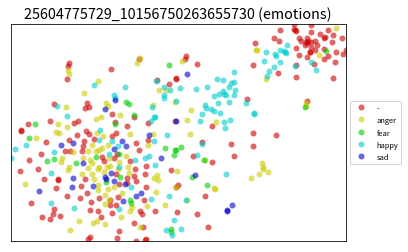

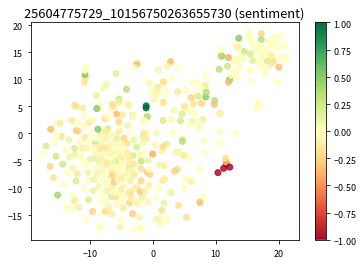

In [78]:
# basic non-interactive plot with emotions and sentiment coloring
basic_viz(ids, emo_main_label[pid], x, y, dict(zip(emotions_list, emotions_list)), pid + " (emotions)")
plt.figure()
plt.scatter(x, y, c=[sent_scores[pid][i] for i in ids], alpha=0.8, cmap="RdYlGn")
plt.colorbar()
plt.title(pid + " (sentiment)");

In [79]:
# interactive plots
fig_emo = create_fig_cats(ids, emo_main_label[pid], x, y, textdict, pid + " (emotions)")
fig_sent = create_fig_scores(ids, sent_scores[pid], x, y, textdict, pid + " (sentiment)")

py.iplot(fig_emo)
py.iplot(fig_sent)

### Compute basic stats

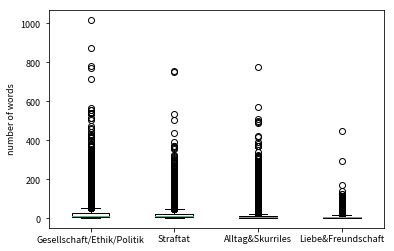

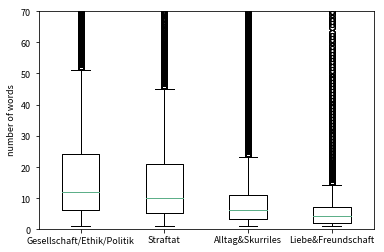

In [83]:
# number of words in comments based on post category
n_words = []
categories = ['Gesellschaft/Ethik/Politik', 'Straftat', 'Alltag&Skurriles', 'Liebe&Freundschaft']
for post_cat in categories:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if post_categories[pid] == post_cat])
plt.figure()
plt.boxplot(n_words, labels=categories)
plt.ylabel("number of words")
plt.figure()
plt.boxplot(n_words, labels=categories)
plt.ylabel("number of words")
plt.ylim([0,70]);

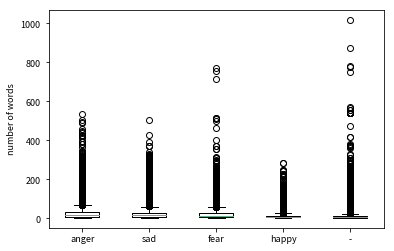

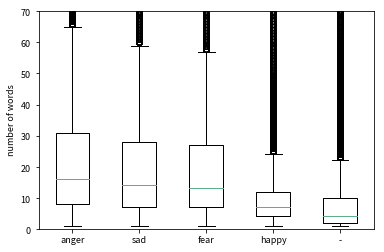

In [81]:
# number of words in comments based on comment emotion
n_words = []
for emo in ["anger", "sad", "fear", "happy", "-"]:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if emo_main_label[pid][i] == emo])
plt.figure()
plt.boxplot(n_words, labels=["anger", "sad", "fear", "happy", "-"])
plt.ylabel("number of words")
plt.figure()
plt.boxplot(n_words, labels=["anger", "sad", "fear", "happy", "-"])
plt.ylabel("number of words")
plt.ylim([0,70]);

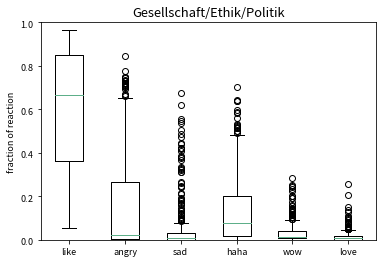

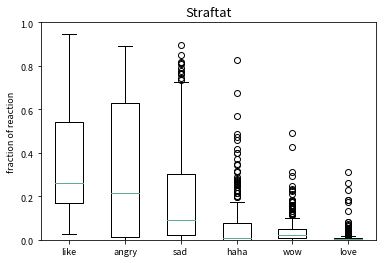

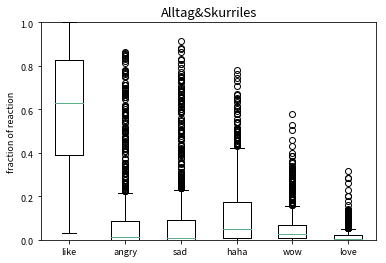

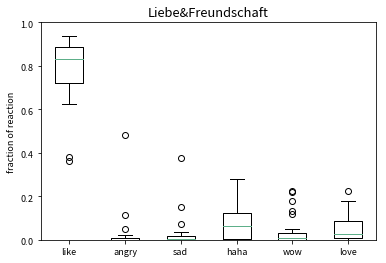

In [91]:
# reactions based on post category
for post_cat in categories:
    reactions = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
            reactions["like"].append(post_likes[pid]/r_total)
            reactions["love"].append(post_love[pid]/r_total)
            reactions["sad"].append(post_sad[pid]/r_total)
            reactions["haha"].append(post_haha[pid]/r_total)
            reactions["angry"].append(post_angry[pid]/r_total)
            reactions["wow"].append(post_wow[pid]/r_total)
    r_labels = ["like", "angry", "sad", "haha", "wow", "love"]
    reactions = [reactions[r] for r in r_labels]
    plt.figure()
    plt.boxplot(reactions, labels=r_labels)
    plt.ylabel("fraction of reaction")
    plt.title(post_cat)
    plt.ylim([0,1]);

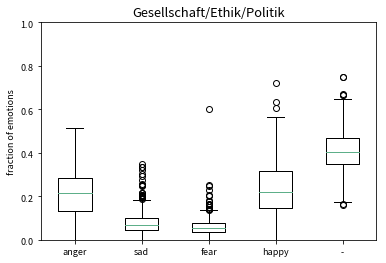

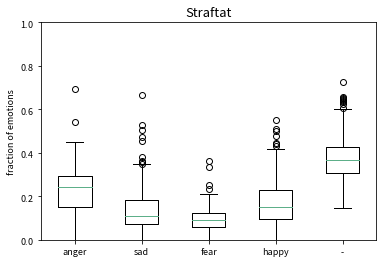

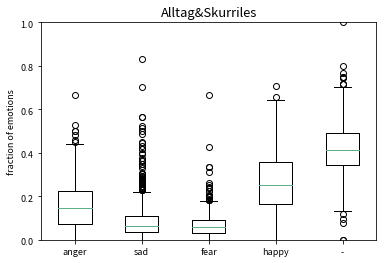

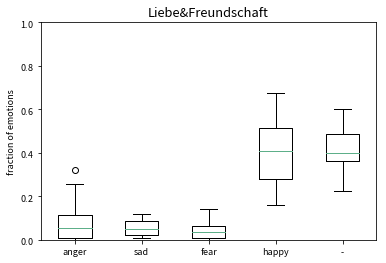

In [90]:
# emotions based on post category
emotions = ["anger", "sad", "fear", "happy", "-"]
for post_cat in categories:
    reactions = {e: [] for e in emotions}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[emo].append(sum([1 for i in emo_main_label[pid] if emo_main_label[pid][i] == emo])/r_total)
    reactions = [reactions[r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions, labels=emotions)
    plt.ylabel("fraction of emotions")
    plt.title(post_cat)
    plt.ylim([0,1]);